# Amazone Fine Food Review Analysis 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

   Number of reviews: 568,454<br>
   Number of users: 256,059<br>
   Number of products: 74,258<br>
   Timespan: Oct 1999 - Oct 2012<br>
   Number of Attributes/Columns in data: 10 

Attribute Information:

   1. Id
   2. ProductId - unique identifier for the product
   3. UserId - unqiue identifier for the user
   4. ProfileName
   5. HelpfulnessNumerator - number of users who found the review helpful
   6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
   7. Score - rating between 1 and 5
   8. Time - timestamp for the review
   9. Summary - brief summary of the review
   10. Text - text of the review



In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  TimeSeriesSplit
from datetime import datetime
import seaborn as sns
import scikitplot.metrics as skplt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import gensim
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
from wordcloud import WordCloud
from sklearn.preprocessing import normalize

## Loading Data

In [10]:
final = pd.read_csv("final.csv") #retriving the sorted dataframe

In [11]:
final = final.iloc[:100000] #taking initial 100k points

## Function

In [12]:
# defining model function that does cross validation ,plot  error, test accuracy and confusion matrix
# this function takes  'X_train', 'X_test', 'y_train', 'y_test' as arguments

def rf(X_train, X_test, y_train, y_test):
    
    
    start=datetime.now()
    #Normalize Data
    X_train = normalize(X_train)
    print ("Train Data Size: ",X_train.shape)
    #Normalize Data
    X_test = normalize(X_test)
    print ("Test Data Size: ",X_test.shape)
    
    estimator=RandomForestClassifier(class_weight = "balanced")
    base=list(range(25,300,25))
    hyperparameter={'n_estimators':base}
    print("Random Forest Classifier")     
    #tscv=TimeSeriesSplit(n_splits=5)    
    clf=GridSearchCV(estimator=estimator, param_grid=hyperparameter,n_jobs=-1,verbose=1,scoring= "f1_micro")
    clf.fit(X_train,y_train)
    
    best_base=clf.best_estimator_.get_params()['n_estimators']
    print('n_estimators = ',best_base)
    
    x_1=[]
    y_1=[]
    
    for x in clf.grid_scores_:
        x_1.append(x[0]['n_estimators'])
        y_1.append(1-x[1])
        
    plt.plot(x_1,y_1, label=' ')
    plt.xlabel('number of base learner')
    plt.ylabel('misclassification error')
    plt.title('base learner vs error')
    plt.legend()
    plt.show()
    
    #Testing Accuracy on Test data
    test=RandomForestClassifier(n_estimators = best_base)
    print("Test RandomForestClassifier")
    
    
    test.fit(X_train,y_train)
    y_pred = test.predict(X_test) 
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')
    #skplt.plot_confusion_matrix(y_test ,y_pred)
    
    end=datetime.now()
    print('duration = ',(end-start))
   
    return best_base

In [13]:
# defining model function that does cross validation ,plot  error, test accuracy and confusion matrix
# this function takes  'X_train', 'X_test', 'y_train', 'y_test' as arguments

def gbdt(X_train, X_test, y_train, y_test):
    
    
    start=datetime.now()
    
    #Normalize Data
    X_train = normalize(X_train)
    print ("Train Data Size: ",X_train.shape)
    #Normalize Data
    X_test = normalize(X_test)
    print ("Test Data Size: ",X_test.shape)
    print("XGradientBoostingClassifier")
    
    
    base=list(range(25,375,25))
    max_depth=[1, 2, 3, 4, 5, 6, 7]
    hyperparameter={'n_estimators':base, 'max_depth':max_depth}
    #tscv=TimeSeriesSplit(n_splits=5)
    model=xgb.XGBClassifier()
    clf=GridSearchCV(estimator=model, param_grid=hyperparameter,n_jobs=-1, verbose=1,scoring= "f1_micro")
    clf.fit(X_train,y_train)
    
    best_base=clf.best_estimator_.get_params()['n_estimators']
    print("best base",best_base)
    best_max_depth=clf.best_estimator_.get_params()['max_depth']
    print("best max depth",best_max_depth)
    
    x_1=[] #for 1st hyperparameter
    y_1=[] #for 2st hyperparameter
    z_1=[] #for error value
    
    for x in clf.grid_scores_:
        x_1.append(x[0]['n_estimators'])
        y_1.append(x[0]['max_depth'])
        z_1.append(1-x[1])
     
    test=xgb.XGBClassifier(max_depth = best_max_depth,n_estimators=best_base)
    print("Test GradientBoostingClassifier")
    
    test.fit(X_train,y_train)
    y_pred = test.predict(X_test) 
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')
    
    
    end=datetime.now()
    print('duration = ',(end-start))
    
    return x_1,y_1,z_1,best_max_depth,best_base

# 1.Bag Of Word 

   The bag-of-words model is a simplifying representation used in natural language processing and information retrieval(IR).Also known as the vector space model.The bag-of-words model is commonly used in methods of document classification where the occurrence of each word is used as a feature for training a classifier.OR
   Simply,Converting a collection of text documents to a matrix of token counts

In [14]:
X_sample = final["CleanedText"] #taking cleandtext as X
y_sample = final["Score"] #taking score as y

## 1.1  BOW with Random Forest

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Random Forest Classifier
Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed: 32.7min finished


n_estimators =  25


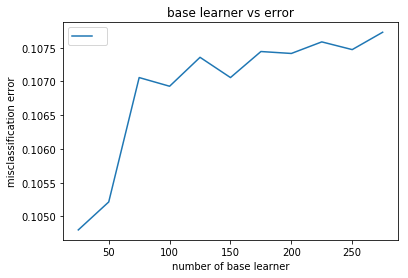

Test RandomForestClassifier
Accuracy on test set: 87.780%
Precision on test set: 0.877
Recall on test set: 0.998
F1-Score on test set: 0.934
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:33:55.037644


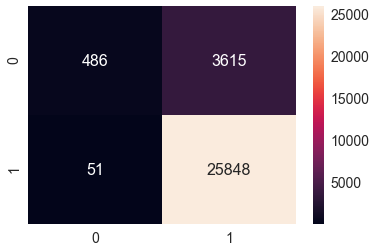

In [15]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer() 

X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

base = rf(X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### WordCloud

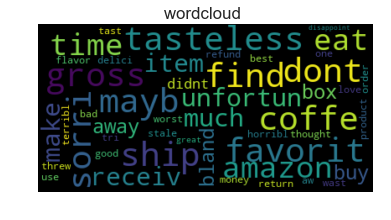

In [16]:
#feature importance
clf=RandomForestClassifier(n_estimators=base)
clf.fit(X_train,y_train)
top=clf.feature_importances_
s=np.argsort(top)[-50:]
feature=count.get_feature_names()
word=[]
for i in range(50):
    index=s[i]
    word.append(feature[index])
word = ' '.join(word)

wordcloud  = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.title("wordcloud ")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 1.2 BOW with GBDT

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
XGradientBoostingClassifier
Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed: 117.6min finished


best base 350
best max depth 7
Test GradientBoostingClassifier
Accuracy on test set: 91.047%
Precision on test set: 0.916
Recall on test set: 0.987
F1-Score on test set: 0.950
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  2:04:52.334440


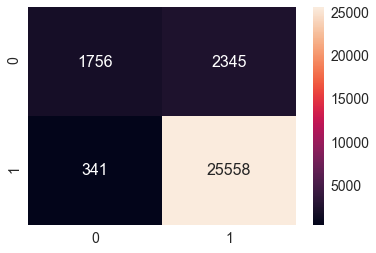

In [9]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer() 

X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

x,y,z,max_depth,base = gbdt(X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)


### Plot Heatmap of error getting through GridsearchCV on both Hyperparameter

In [10]:
x = np.unique(x) #value of 1st hyperparameter max_depth plot on Y axis
y = np.unique(y) #value of 2st hyperparameter base plot on X axis
z = np.array(z).reshape((7,14)) #converting into 2d array

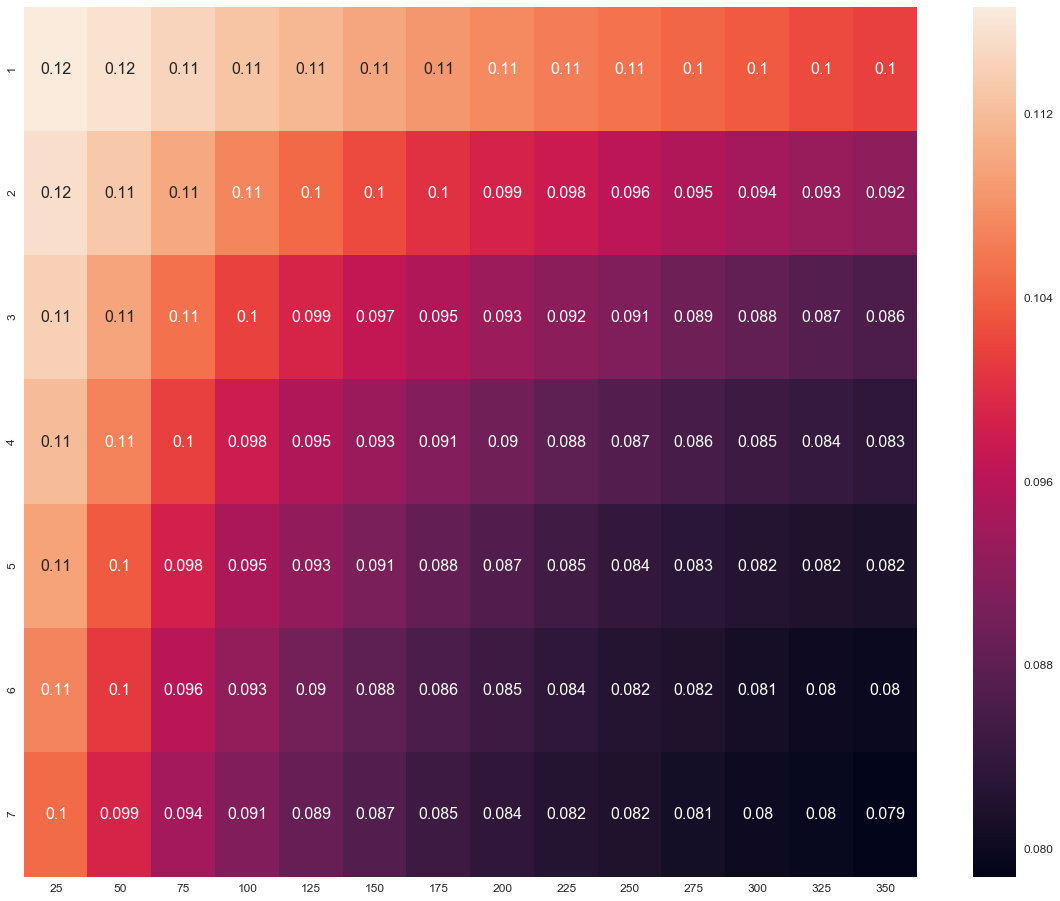

In [11]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)#for label size
sns.heatmap(z, annot=True,annot_kws={"size": 16},xticklabels=x, yticklabels=y)
#plt.show()

###  WordCloud

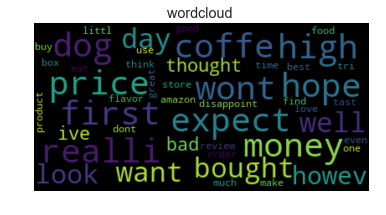

In [12]:
#feature importance
clf=xgb.XGBClassifier(max_depth=max_depth,n_estimators=base)
clf.fit(X_train,y_train)
top=clf.feature_importances_
s=np.argsort(top)[-50:]
feature=count.get_feature_names()
word=[]
for i in range(50):
    index=s[i]
    word.append(feature[index])
word = ' '.join(word)

wordcloud  = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.title("wordcloud ")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 2.TFIDF

## 2.1 TFDIF with Random Forest

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Random Forest Classifier
Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed: 48.2min finished


n_estimators =  25


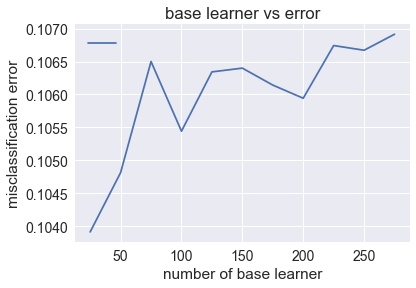

Test RandomForestClassifier
Accuracy on test set: 87.857%
Precision on test set: 0.878
Recall on test set: 0.998
F1-Score on test set: 0.934
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:50:54.329912


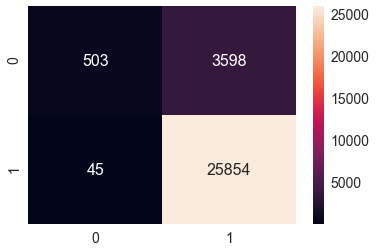

In [17]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample,train_size=0.7,shuffle=False,random_state=0)

tfidf = TfidfVectorizer(ngram_range=(1,1), binary=True)

X_train = tfidf.fit_transform(X_train)

X_test = tfidf.transform(X_test)



base = rf(X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)


###  WordCloud

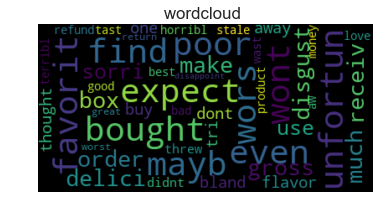

In [18]:
#feature importance
clf=RandomForestClassifier(n_estimators=base)
clf.fit(X_train,y_train)
top=clf.feature_importances_
s=np.argsort(top)[-50:]
feature=count.get_feature_names()
word=[]
for i in range(50):
    index=s[i]
    word.append(feature[index])
word = ' '.join(word)

wordcloud  = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.title("wordcloud ")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2.2 TFDIF with GBDT

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
XGradientBoostingClassifier
Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed: 123.6min finished


best base 350
best max depth 7
Test GradientBoostingClassifier
Accuracy on test set: 91.067%
Precision on test set: 0.916
Recall on test set: 0.987
F1-Score on test set: 0.950
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  2:23:04.113167


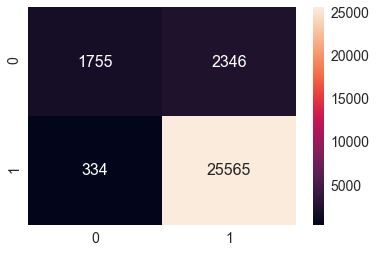

In [15]:
x,y,z,max_depth,base= gbdt(X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test )

### Plot Heatmap of error getting through GridsearchCV on both Hyperparameter

In [16]:
x = np.unique(x) #value of 1st hyperparameter Max_depth plot on Y axis
y = np.unique(y) #value of 2st hyperparameter base plot on X axis
z = np.array(z).reshape((7,14)) #converting into 2d array

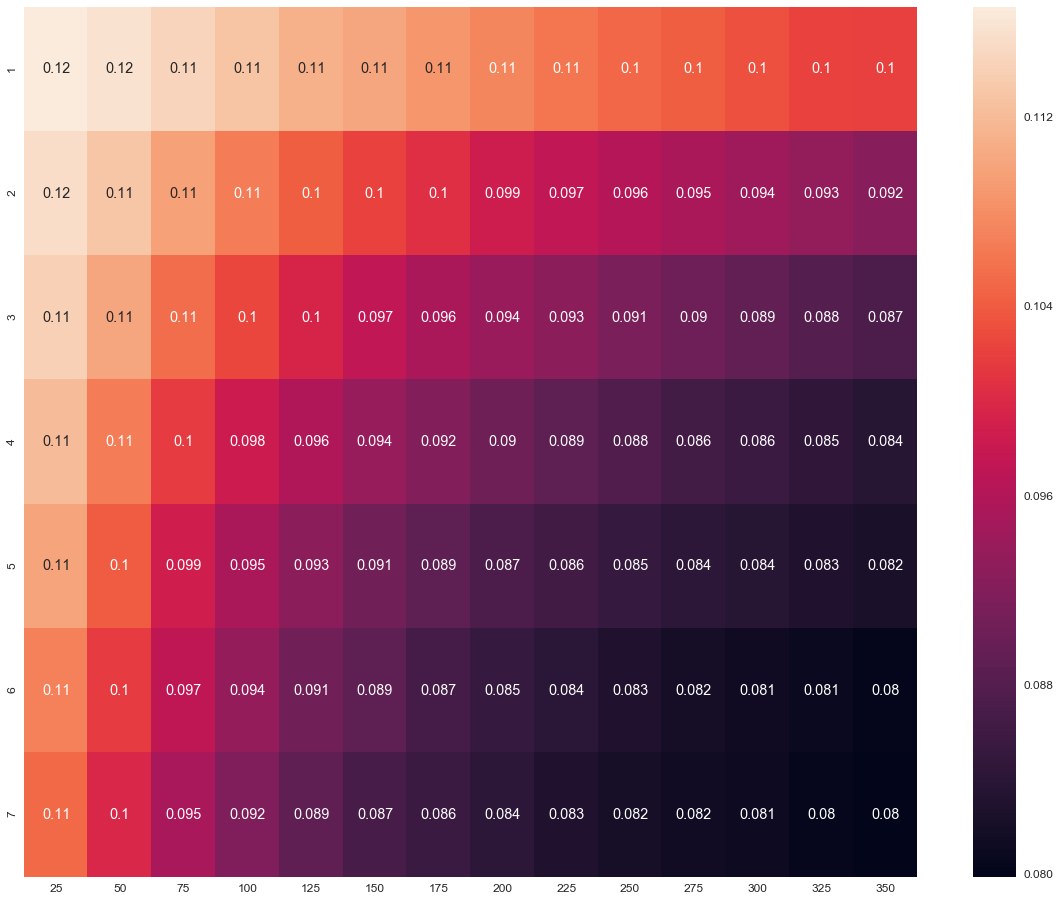

In [17]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)#for label size
sns.heatmap(z, annot=True,xticklabels=x, yticklabels=y)
#plt.show()

### WordCloud

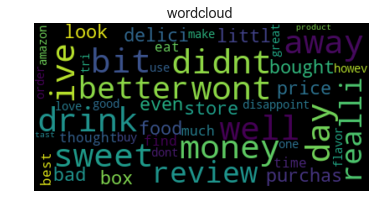

In [18]:
#feature importance
clf=xgb.XGBClassifier(max_depth=max_depth,n_estimators=base)
clf.fit(X_train,y_train)
top=clf.feature_importances_
s=np.argsort(top)[-50:]
feature=count.get_feature_names()
word=[]
for i in range(50):
    index=s[i]
    word.append(feature[index])
word = ' '.join(word)

wordcloud  = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.title("wordcloud ")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3.AVG WORD2VEC

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample,train_size=0.7,shuffle=False,random_state=0)

In [20]:
# Train your own Word2Vec model using your own text corpus
#for train data
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [21]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=4)   

In [22]:
w2v_words_train = list(w2v_model.wv.vocab)

In [23]:
words_train = list(w2v_model.wv.vocab)
print(len(words_train))

10700


In [24]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    list_of_sent_test.append(sent.split())

In [25]:
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=300, workers=4)   

In [26]:
w2v_words_test = list(w2v_model_test.wv.vocab)

In [27]:
words_test = list(w2v_model_test.wv.vocab)
print(len(words_test))

7363


## AVG W2V

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
300


In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word_test in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
300


## 3.1 AVG W2V with Random Forest

Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)
Random Forest Classifier
Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed: 29.0min finished


n_estimators =  50


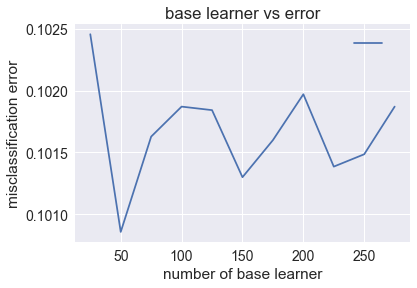

Test RandomForestClassifier
Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:34:54.423918


50

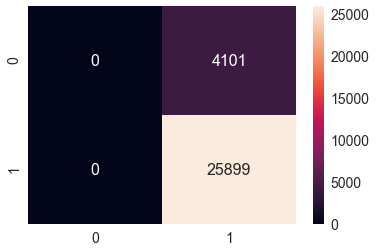

In [30]:
rf(X_train=sent_vectors, X_test=sent_vectors_test, y_train=y_train, y_test=y_test)


## 3.2 AVG W2V with GBDT

In [31]:
X_train=np.array(sent_vectors)

Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)
XGradientBoostingClassifier
Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 221.5min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed: 478.4min finished


best base 350
best max depth 6
Test GradientBoostingClassifier
Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  8:35:54.322425


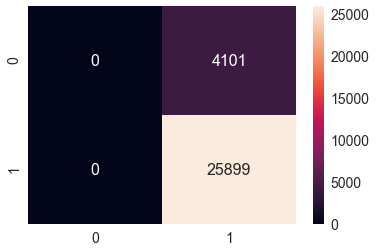

In [32]:
x,y,z,max_depth,base= gbdt(X_train=X_train, X_test=sent_vectors_test, y_train=y_train, y_test=y_test)

### Plot Heatmap of error getting through GridsearchCV on both Hyperparameter

In [33]:
x = np.unique(x) #value of 1st hyperparameter max_depth plot on Y axis
y = np.unique(y) #value of 2st hyperparameter base plot on X axis
z = np.array(z).reshape((7,14)) #converting into 2d array

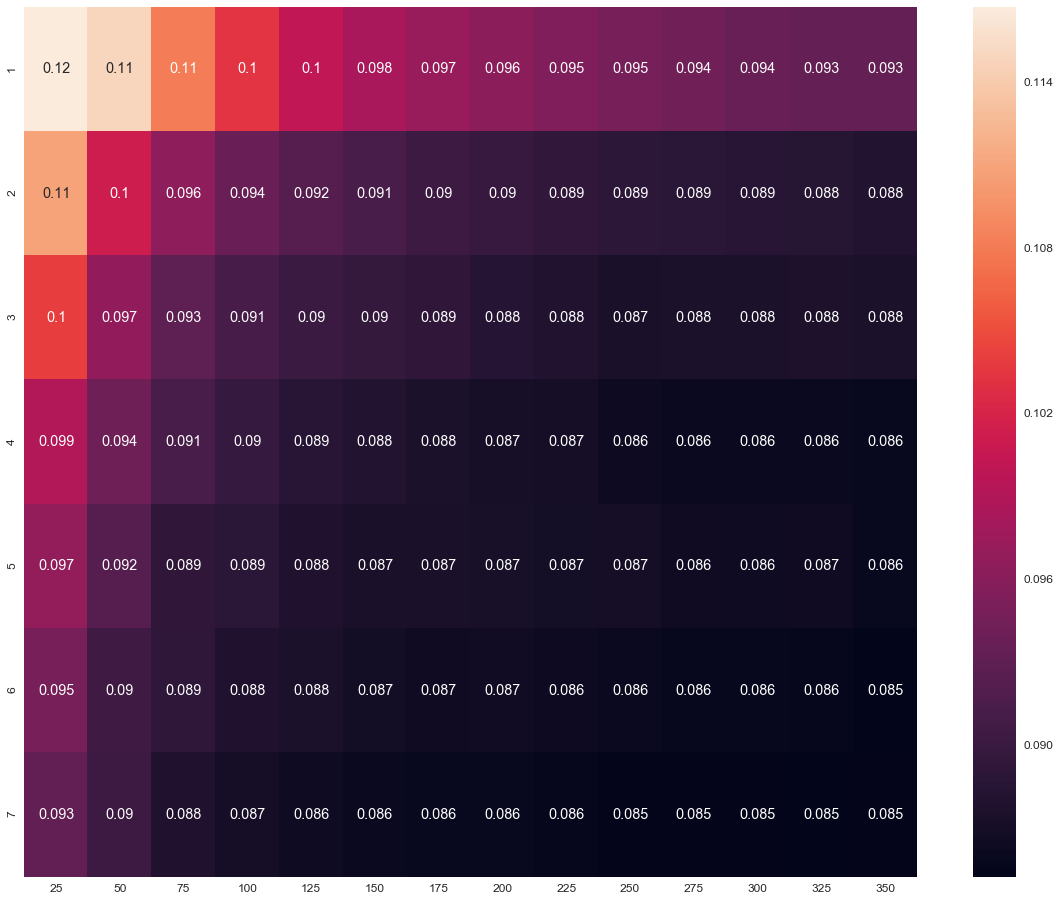

In [34]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)#for label size
sns.heatmap(z, annot=True,xticklabels=x, yticklabels=y)
#plt.show()

# 4. TFDIF WORD2VEC

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample,train_size=0.7,shuffle=False,random_state=0)

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
tfidf_idf_matrix_test = model.transform(X_test.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word_train in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [03:31<00:00, 331.05it/s]


70000
300


In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word_test in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:27<00:00, 1102.56it/s]


30000
300


## 4.1  TFDIF WORD2VEC with Random Forest

Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)
Random Forest Classifier
Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  7.6min finished


n_estimators =  25


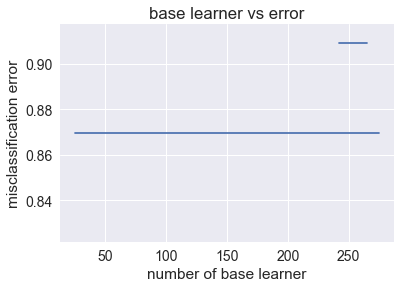

Test RandomForestClassifier
Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  0:07:52.370185


25

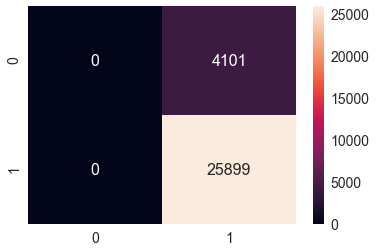

In [35]:
rf(X_train =tfidf_sent_vectors, X_test=tfidf_sent_vectors_test, y_train=y_train, y_test=y_test)

## 4.2 TFDIF WORD2VEC with GBDT

In [40]:
X_train=np.array(tfidf_sent_vectors)

Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)
XGradientBoostingClassifier
Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 69.2min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed: 149.1min finished


best base 25
best max depth 1
Test GradientBoostingClassifier
Accuracy on test set: 86.330%
Precision on test set: 0.863
Recall on test set: 1.000
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

duration =  2:29:28.983695


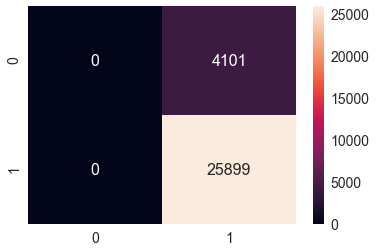

In [41]:
x,y,z,max_depth,base= gbdt(X_train=X_train, X_test=tfidf_sent_vectors_test, y_train=y_train, y_test=y_test)

### Plot Heatmap of error getting through GridsearchCV on both Hyperparameter

In [42]:
x = np.unique(x) #value of 1st hyperparameter max_depth plot on Y axis
y = np.unique(y) #value of 2st hyperparameter base plot on X axis
z = np.array(z).reshape((7,14)) #converting into 2d array

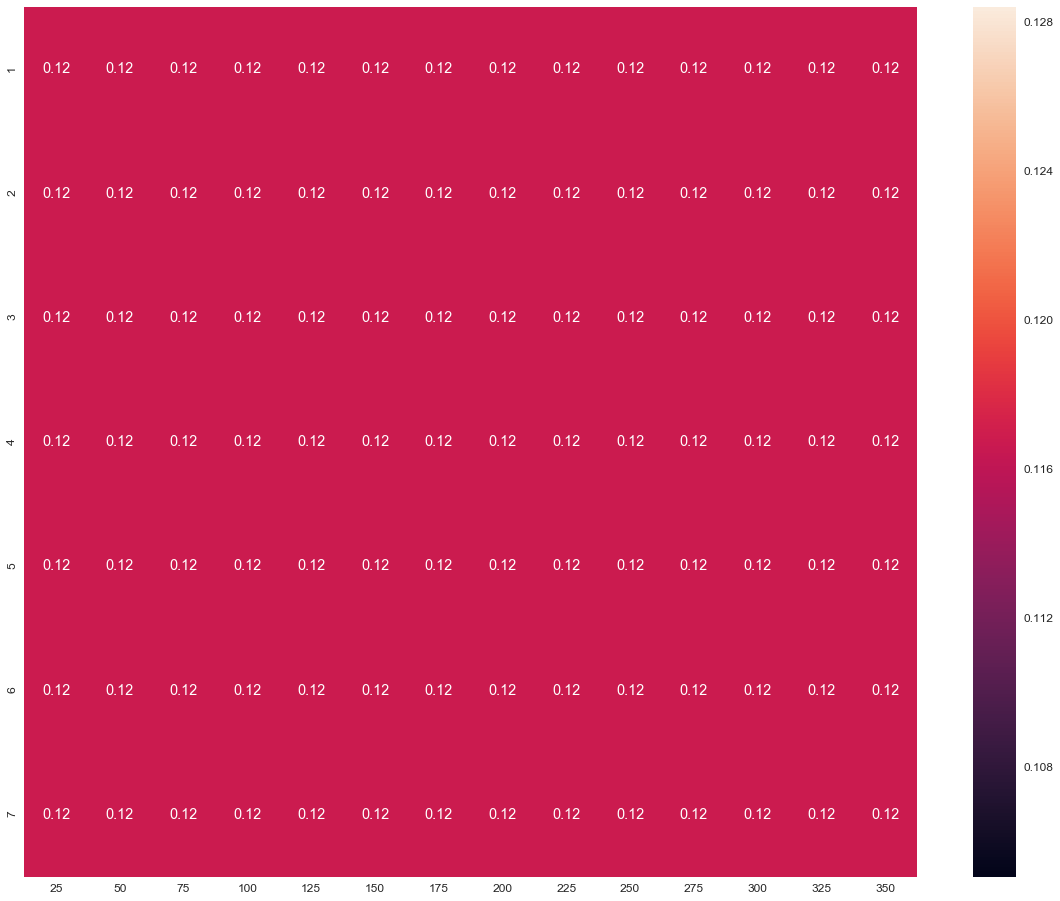

In [43]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)#for label size
sns.heatmap(z, annot=True,xticklabels=x, yticklabels=y)
#plt.show()

## Performance Table

|sno	|featurization	|model algo	|cv algo	|best n_estimators	|accuracy| Precision |Recall| f1-score |
|-------|---------------|-----------|-----------|------------------|--------|-----------|------|----------|
|1	|BoW|RandomForestClassifier|GridSearchCV|25|87.780%|0.877|0.998|0.934|
|2	|TFIDF|RandomForestClassifier|GridSearchCV|25|87.857%|0.878|0.998|0.934|
|3	|AVG W2V|RandomForestClassifier|GridSearchCV|50|86.330%|0.863|1.000|0.927|
|4	|TFIDF W2V|RandomForestClassifier|GridSearchCV|25|86.330%|0.863|1.000|0.927|

|sno	|featurization	|model algo	|cv algo	|best n_estimators	|best max_depth|accuracy| Precision |Recall| f1-score |
|-------|---------------|-----------|-----------|-------------------|--------|-----------|------|----------|---|
|1	|BoW|XGBClassifier|GridSearchCV|350|7| 91.047%|0.916|0.987|0.950|
|2	|TFIDF|XGBClassifier|GridSearchCV|350|7|91.067%|0.916|0.987|0.950|
|3	|AVG W2V|XGBClassifier|GridSearchCV|350|6|86.330%|0.863|1.000|0.927|
|4	|TFIDF W2V|XGBClassifier|GridSearchCV|25|1|86.330%|0.863|1.000|0.927|

## Conclusion-
* On appling RandomForestClassifier and XGBClassifier on amazon fine food review observe following conclusion.
* we use GridSearchCV for for finding best hyperparameter
* we applied four featurization for RandomForestClassifier and XGBClassifier.
* As we can see that recall is so bad especially in every case of RandomForestClassifier seems like dumb model and also not good in XGBClassifier
* Confusion matrix has very bad result in every case of RandomForestClassifier as compair XGBClassifier
* So we can conclude that RandomForestClassifier is not working well for this amazon fine food review dataset.
